In [1]:
import spikeinterface.full as si
si.set_global_job_kwargs(n_jobs=-1)

In [2]:
rec0, gt_sorting0 = si.generate_ground_truth_recording(num_channels=50, durations=[120.], seed=43, num_units=30)

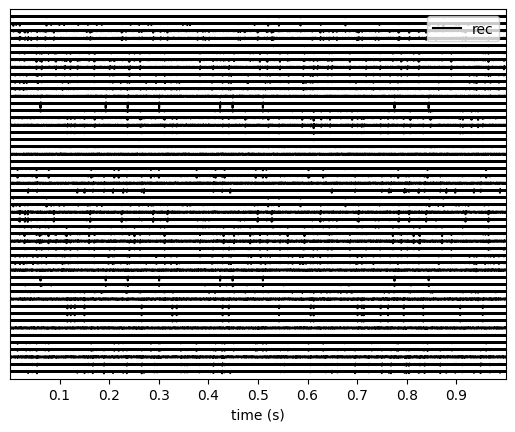

In [3]:
si.plot_traces(rec0)

In [4]:
rec0 = si.bandpass_filter(rec0, freq_min=300, freq_max=6000)

In [5]:
rec0 = si.common_reference(rec0, operator='median',reference= 'global')

In [6]:
sorter_name = "mountainsort4"
default_params = si.get_default_sorter_params(sorter_name)

In [7]:
sorting_folder = "./moutainsort4_sorting"

In [8]:
sorting = si.run_sorter(
    sorter_name=sorter_name,
    recording=rec0,
    folder=sorting_folder,
    remove_existing_folder=True,
    **default_params
)

Mountainsort4 use the OLD spikeextractors mapped with NewToOldRecording


sys:1: DeprecationWarning: Call to deprecated function (or staticmethod) _destroy.
sys:1: DeprecationWarning: Call to deprecated function (or staticmethod) _destroy.


In [10]:
sorting

NpzSortingExtractor: 86 units - 1 segments - 25.0kHz
  file_path: /media/data0/spikeagent/revision/spikeagent_0.102.3_zuwan_test/testing_notebook/moutainsort4_sorting/sorter_output/firings.npz

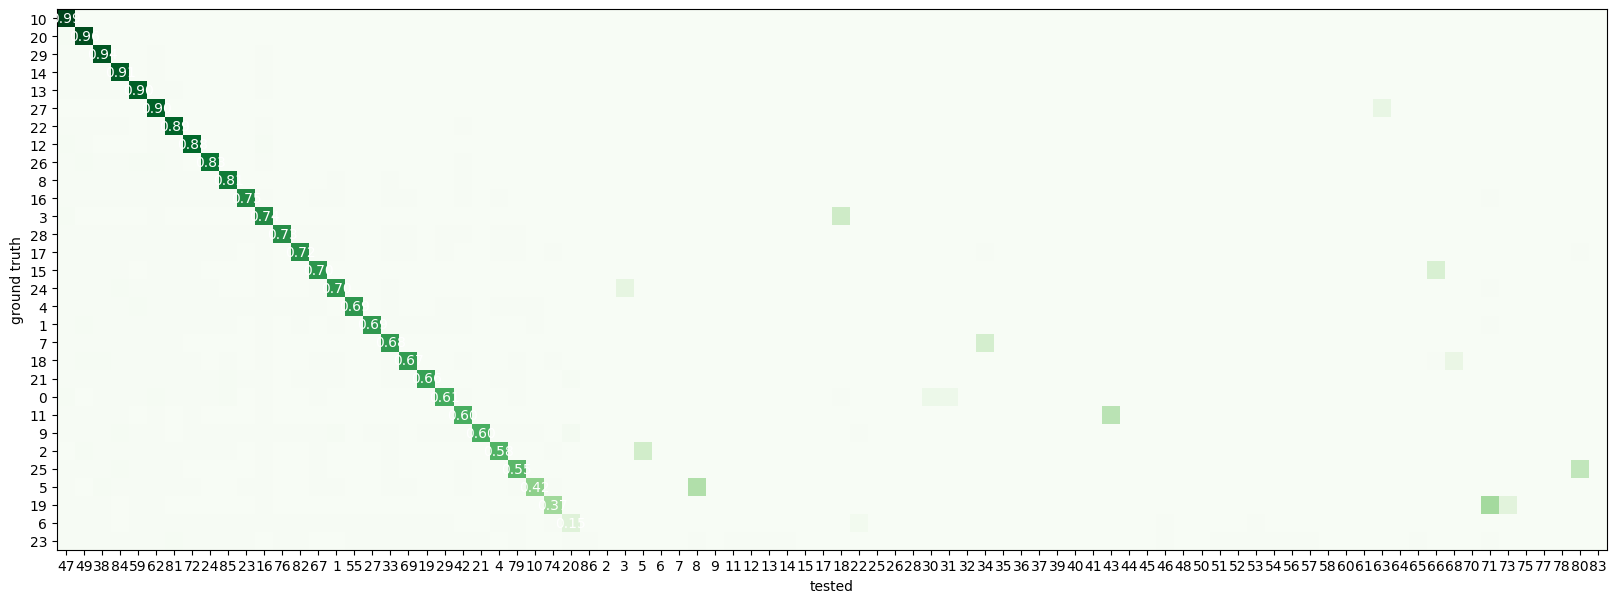

In [11]:
comp_gt = si.compare_sorter_to_ground_truth(gt_sorting=gt_sorting0, tested_sorting=sorting, exhaustive_gt=True)
si.plot_agreement_matrix(comp_gt, figsize=(20, 10))

In [12]:
import sys
import os

# Add the project root to the Python path to allow for package imports
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [13]:
import tool.si_custom as sic

In [14]:
analyzer_folder = sorting_folder + "/sorting_analyzer.zarr"
sorting_analyzer = si.create_sorting_analyzer(
    sorting=sorting,
    recording=rec0,
    format='zarr',
    folder=analyzer_folder,
    overwrite=True
)

estimate_sparsity (workers: 64 processes):   0%|          | 0/120 [00:00<?, ?it/s]

In [15]:
print("\n--- Starting Step 5: Computing analysis extensions ---")
extension_params = {
    "random_spikes": {"method": "uniform", "max_spikes_per_unit": 600},
    "waveforms": {"ms_before": 1.0, "ms_after": 2.0},
    "templates": {},
    "template_similarity": {},
    "spike_locations": {},
    "unit_locations": {},
    "isi_histograms": {"window_ms": 30, "bin_ms": 0.5, "method": "auto"},
    "correlograms": {"window_ms": 30, "bin_ms": 0.5, "method": "auto"},
    "spike_amplitudes": {},
    "noise_levels": {},
    "principal_components": {},
    "quality_metrics": {
        "metric_names": [
            "snr", "firing_rate", "isi_violation",
            "presence_ratio", "amplitude_cutoff", "amplitude_median", 'l_ratio', 'nearest_neighbor',
        ]
    }
}

for key, value in extension_params.items():
    print(f"Computing {key}...")
    extension = sorting_analyzer.get_extension(key)
    if extension is None or not value.items() <= extension.params.items():
        sorting_analyzer.compute(key, **value)
    else:
        print(f"{key} already computed with compatible parameters")

print("All extensions computed successfully.")
print("\n--- SortingAnalyzer after extension computation ---")
print(sorting_analyzer)


--- Starting Step 5: Computing analysis extensions ---
Computing random_spikes...
Computing waveforms...


compute_waveforms (workers: 64 processes):   0%|          | 0/120 [00:00<?, ?it/s]

Computing templates...
Computing template_similarity...
Computing spike_locations...


spike_locations (workers: 64 processes):   0%|          | 0/120 [00:00<?, ?it/s]

Computing unit_locations...
Computing isi_histograms...
Computing correlograms...
Computing spike_amplitudes...


spike_amplitudes (workers: 64 processes):   0%|          | 0/120 [00:00<?, ?it/s]

Computing noise_levels...


noise_level (workers: 20 processes):   0%|          | 0/20 [00:00<?, ?it/s]

Computing principal_components...


Fitting PCA:   0%|          | 0/86 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/86 [00:00<?, ?it/s]

Computing quality_metrics...


/home/arnau/miniconda3/envs/jongmin/lib/python3.11/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:910: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")


calculate_pc_metrics:   0%|          | 0/86 [00:00<?, ?it/s]

All extensions computed successfully.

--- SortingAnalyzer after extension computation ---
SortingAnalyzer: 50 channels - 86 units - 1 segments - zarr - sparse - has recording
Loaded 12 extensions: random_spikes, waveforms, templates, template_similarity, spike_locations, unit_locations, isi_histograms, correlograms, spike_amplitudes, noise_levels, principal_components, quality_metrics


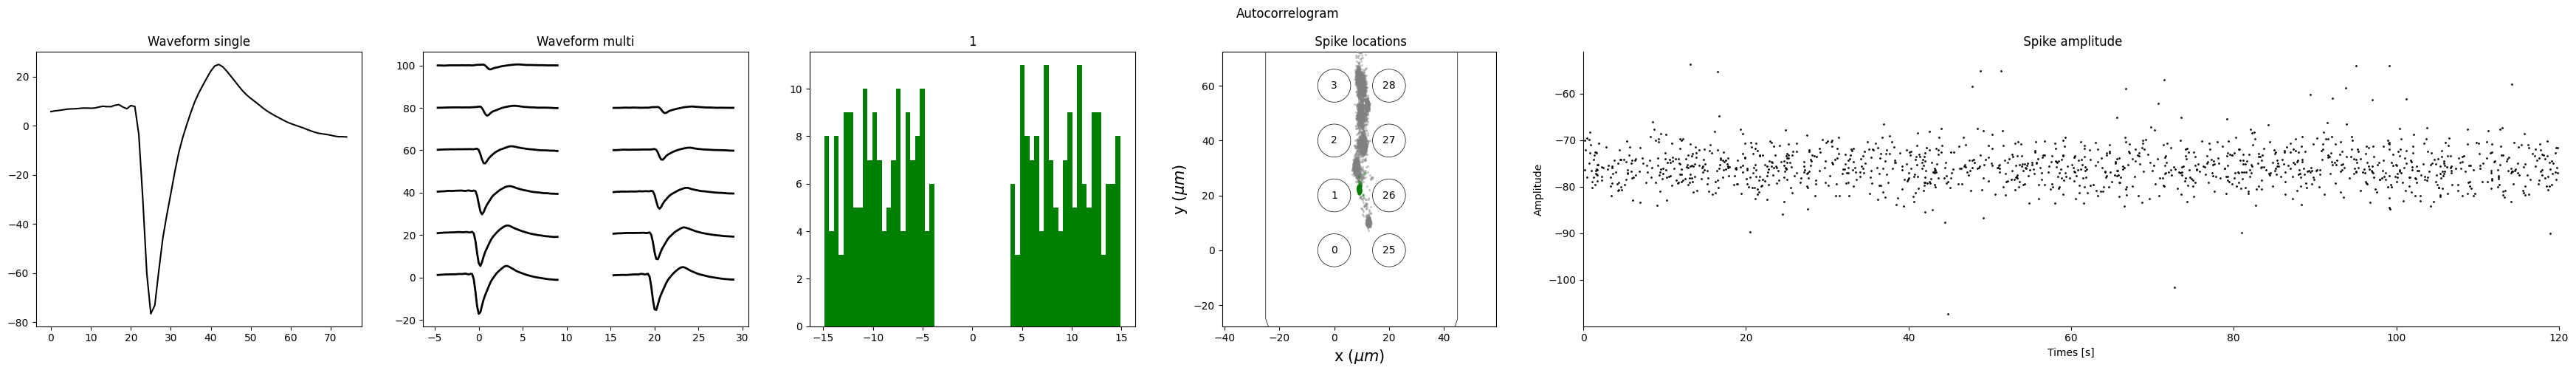

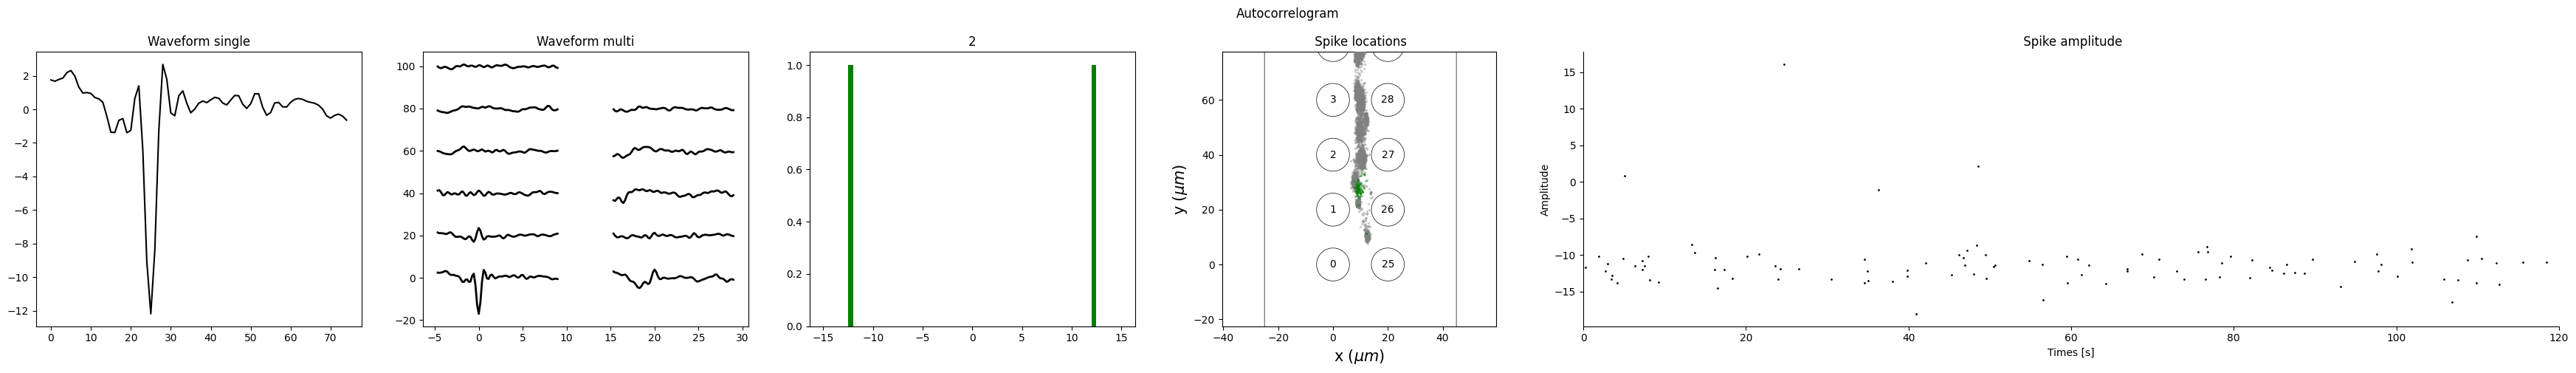

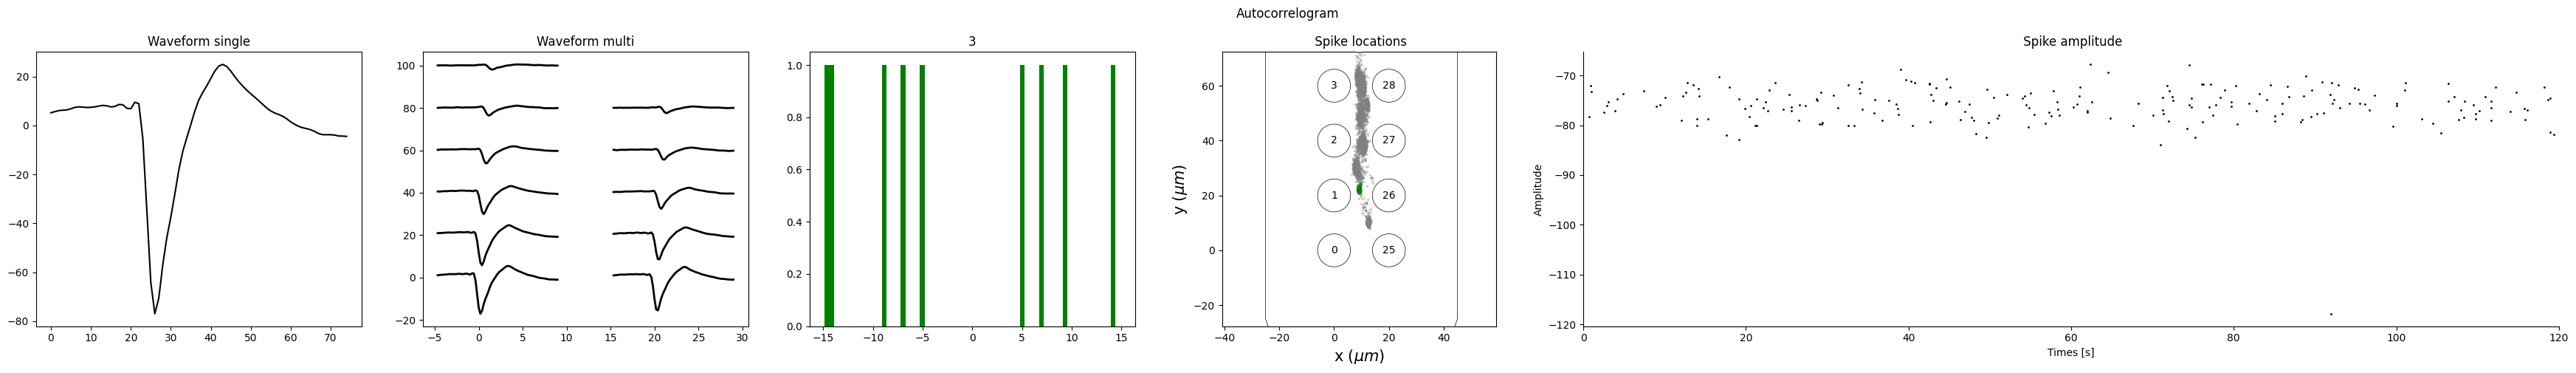

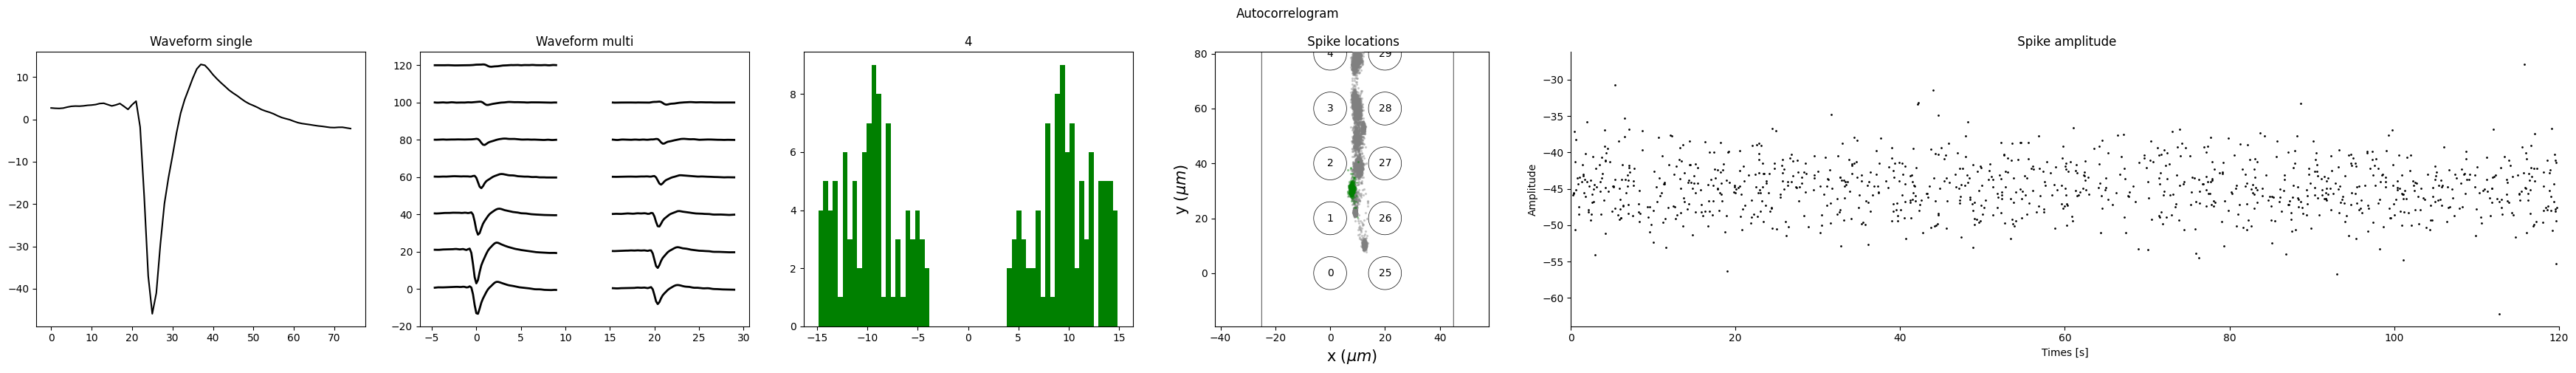

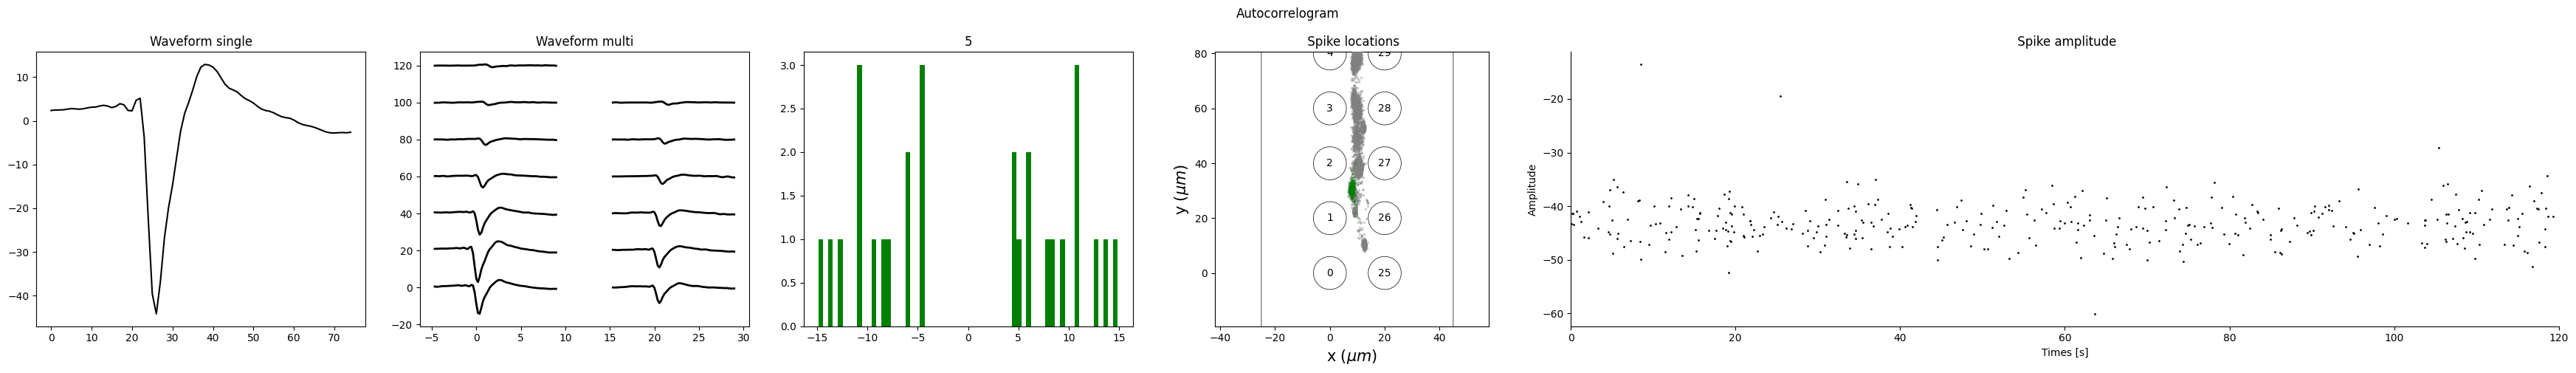

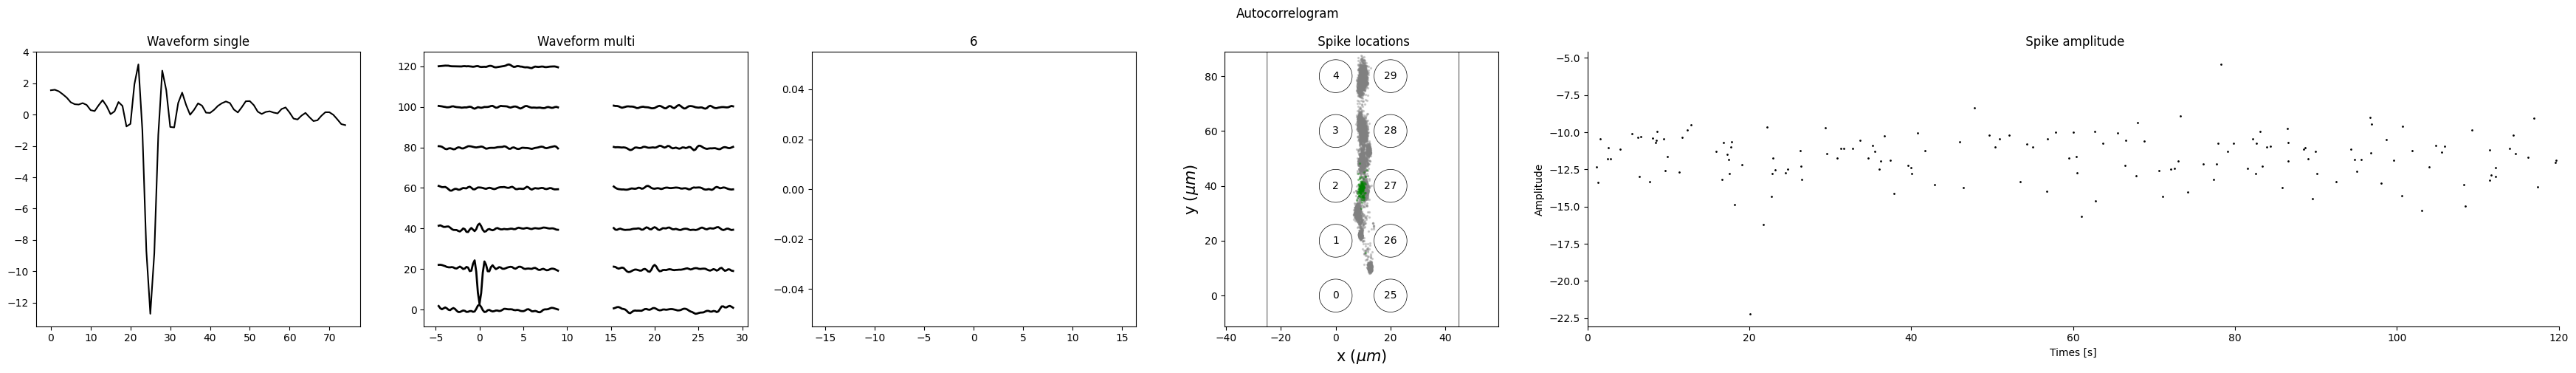

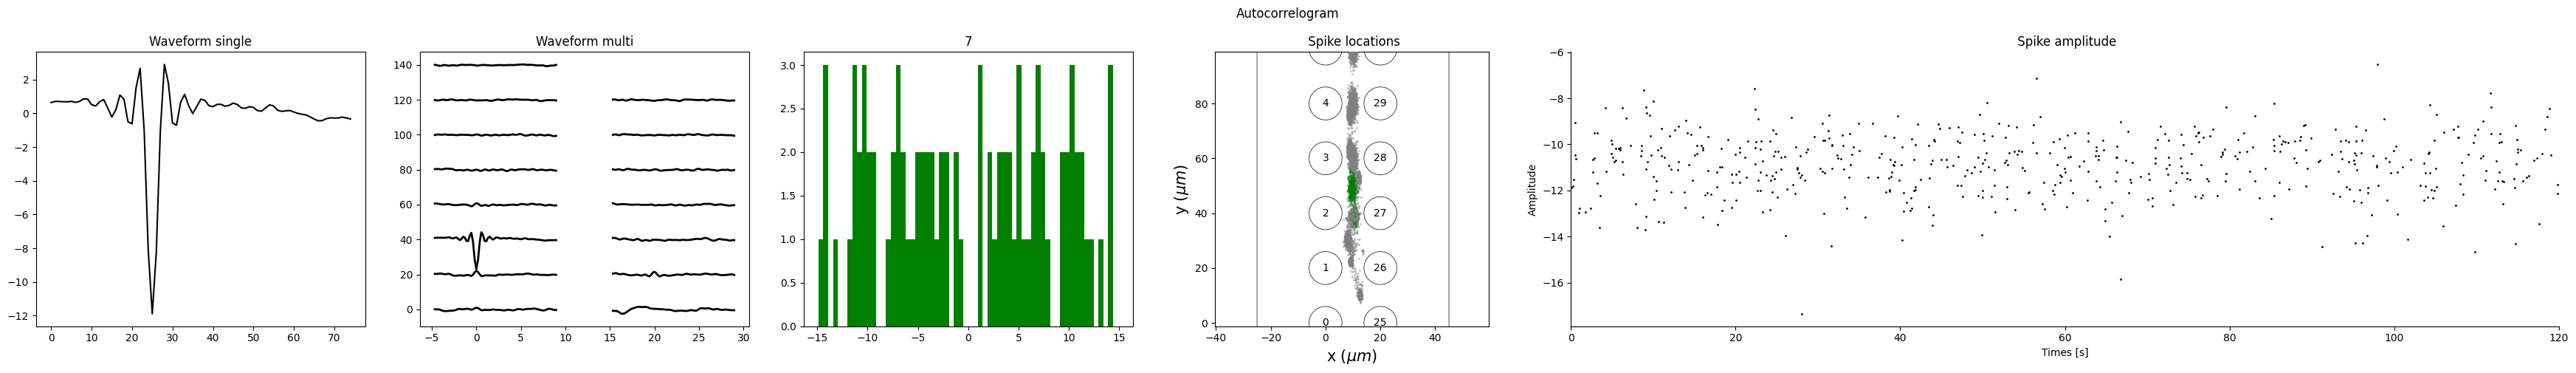

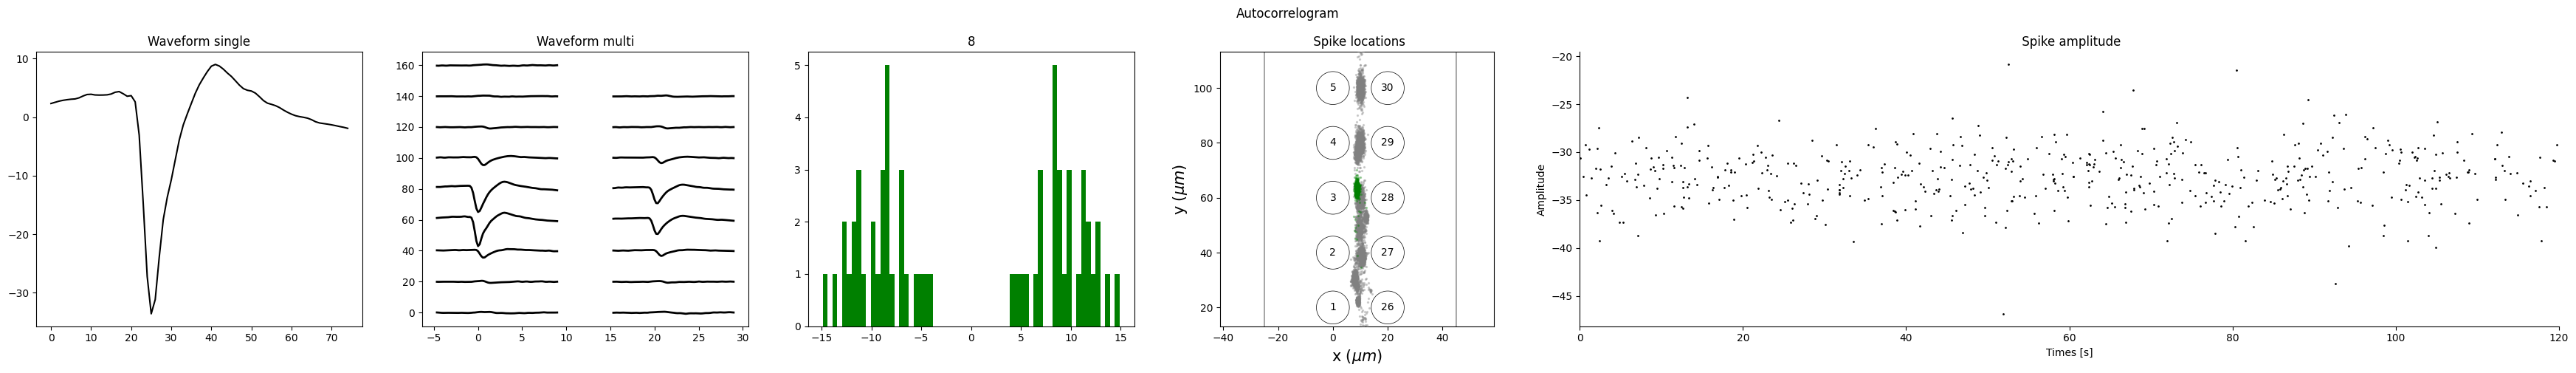

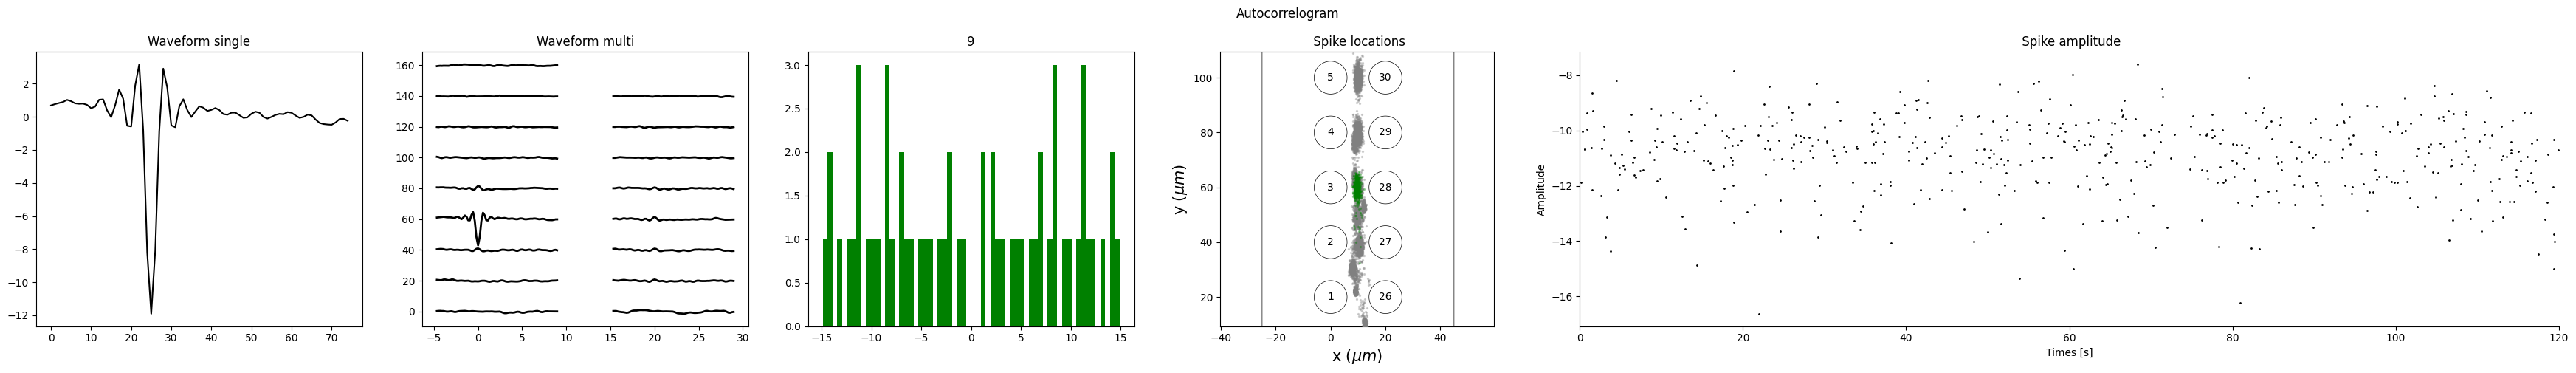

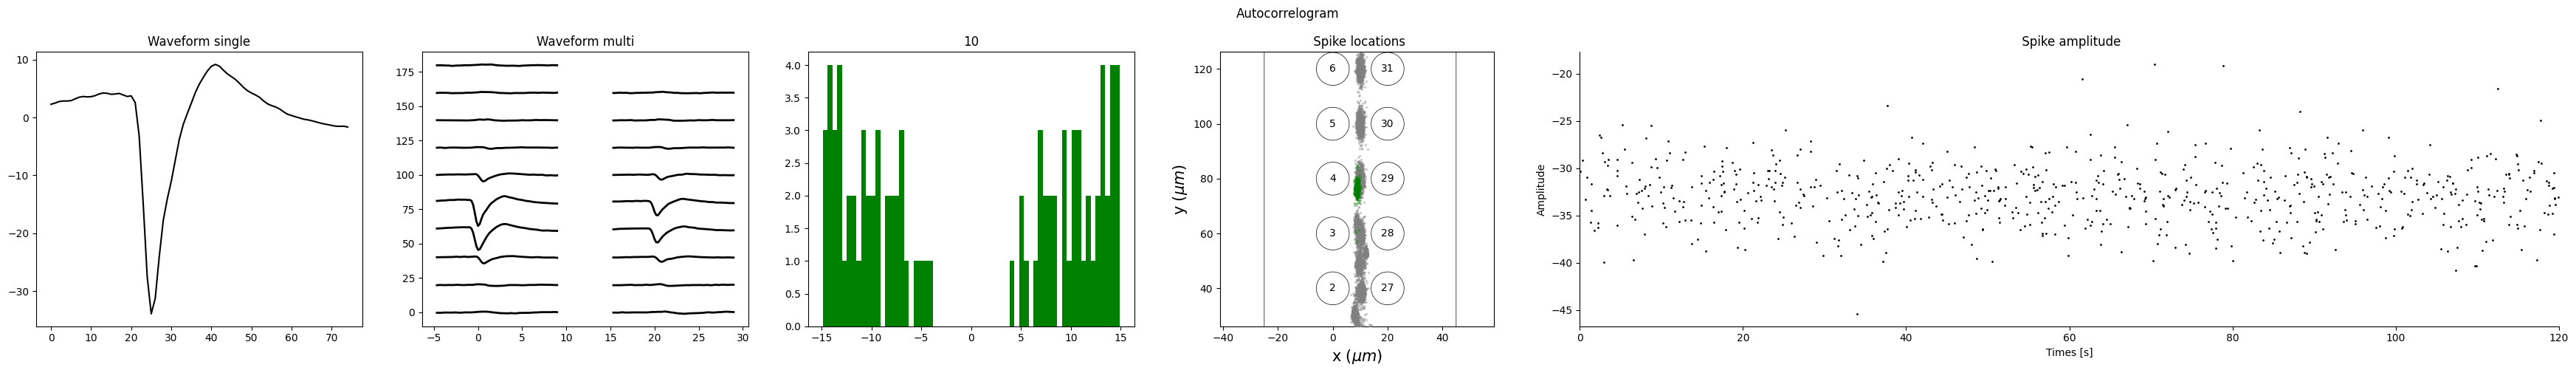

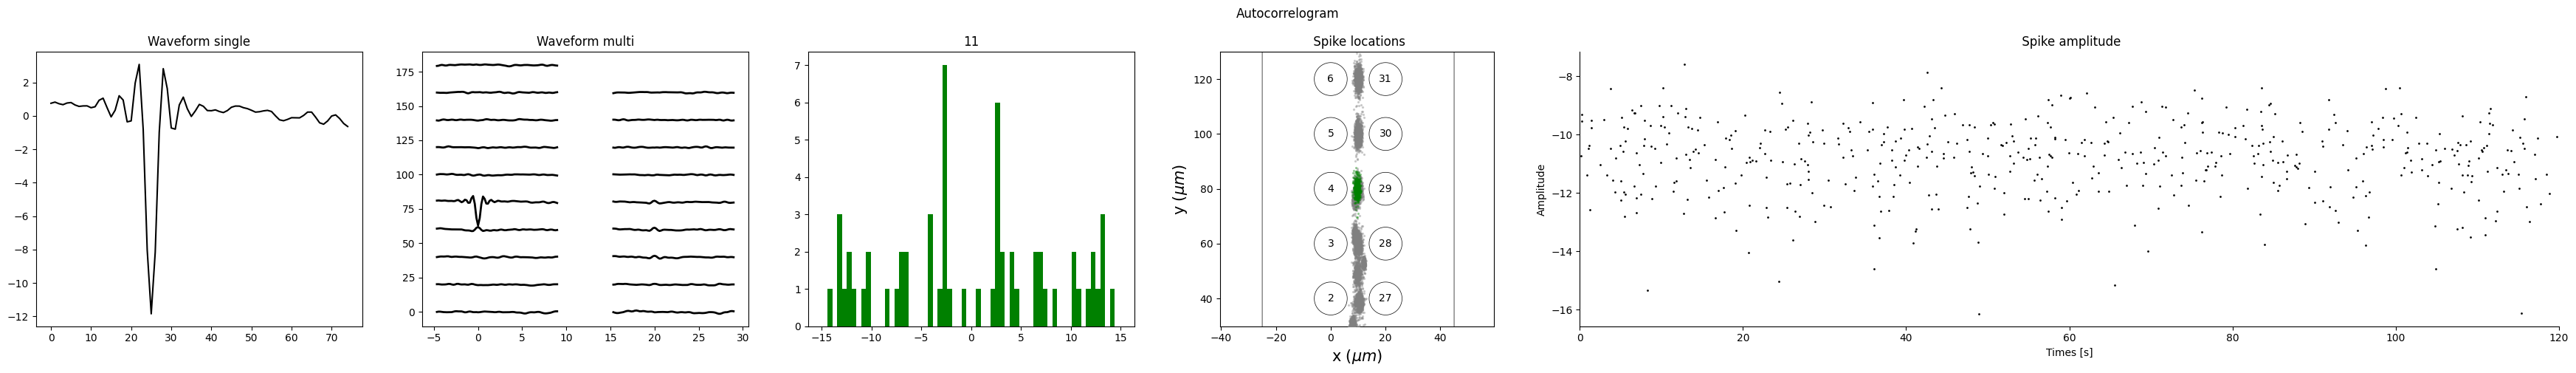

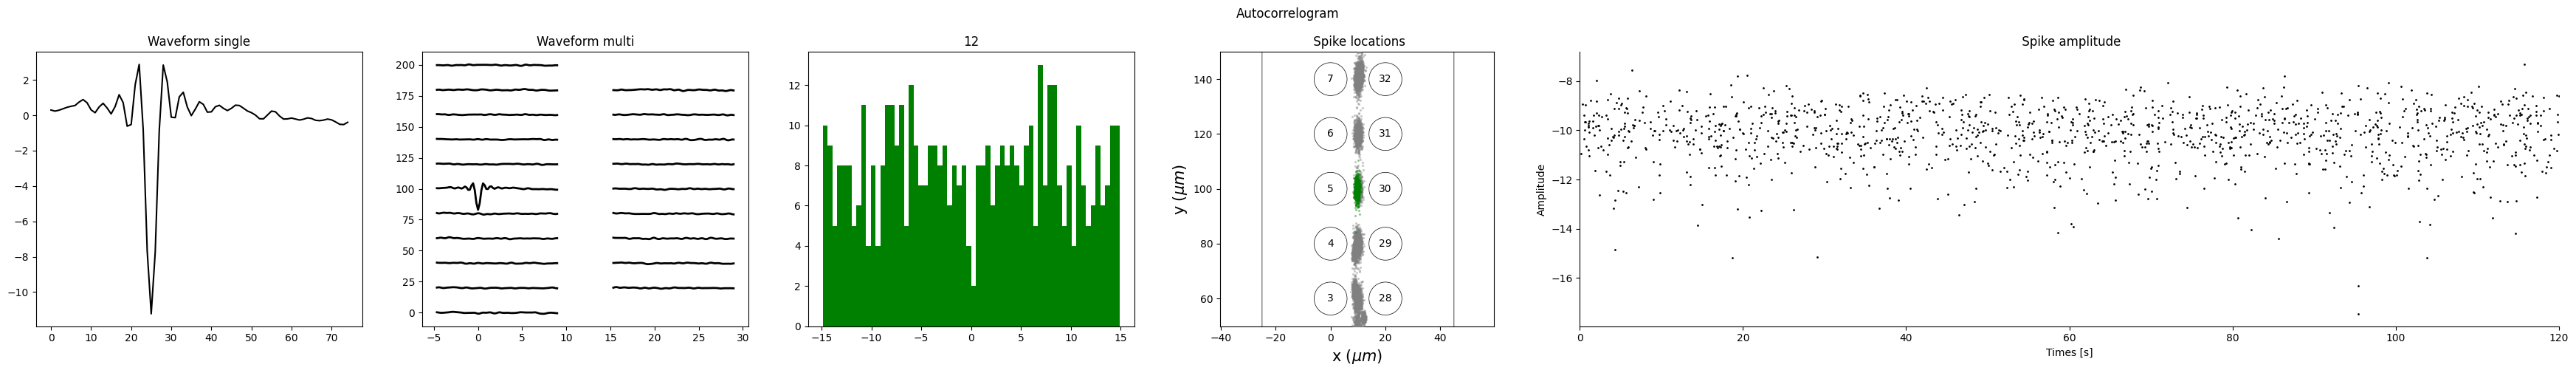

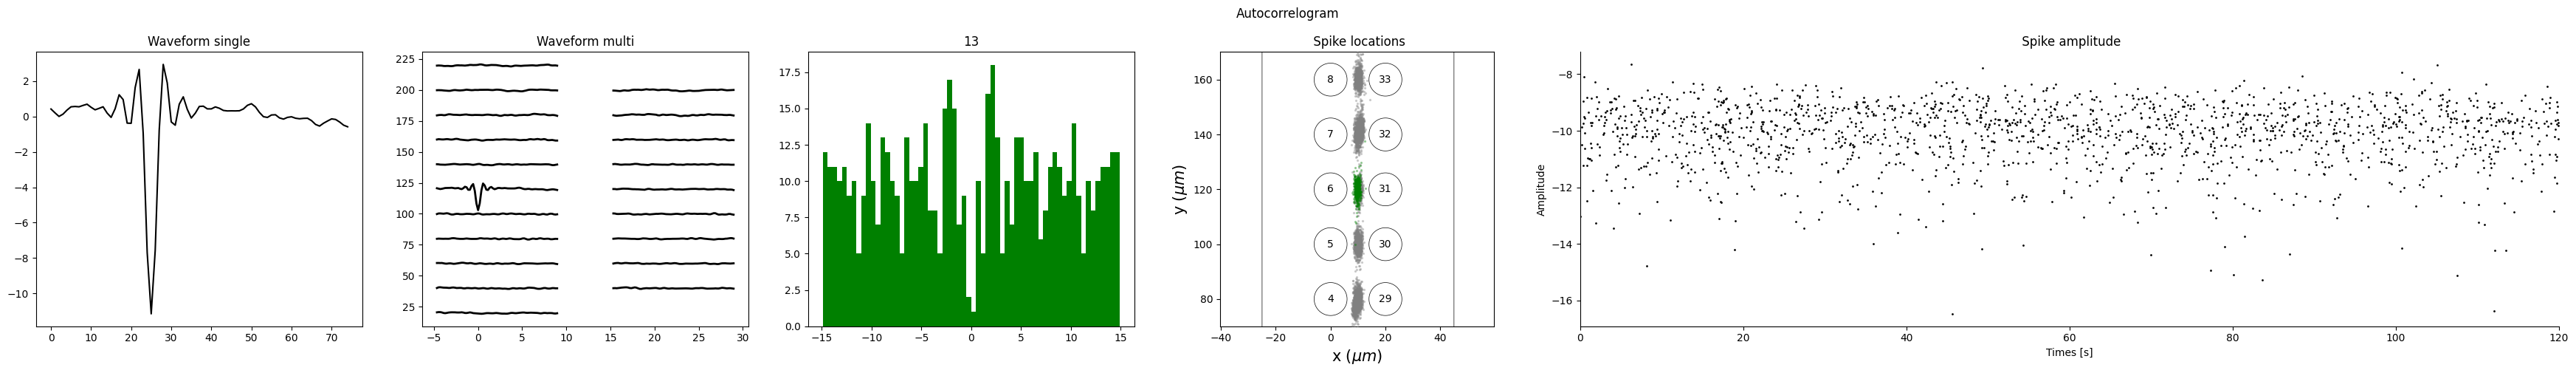

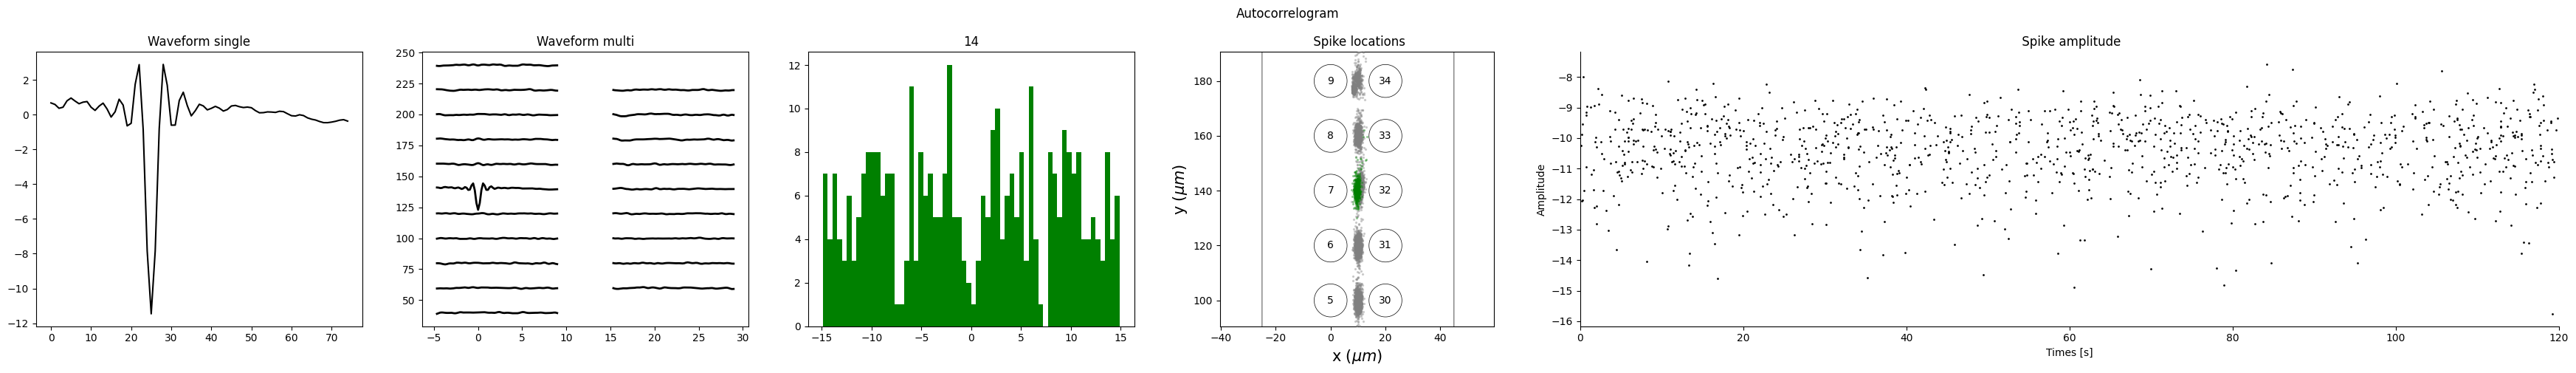

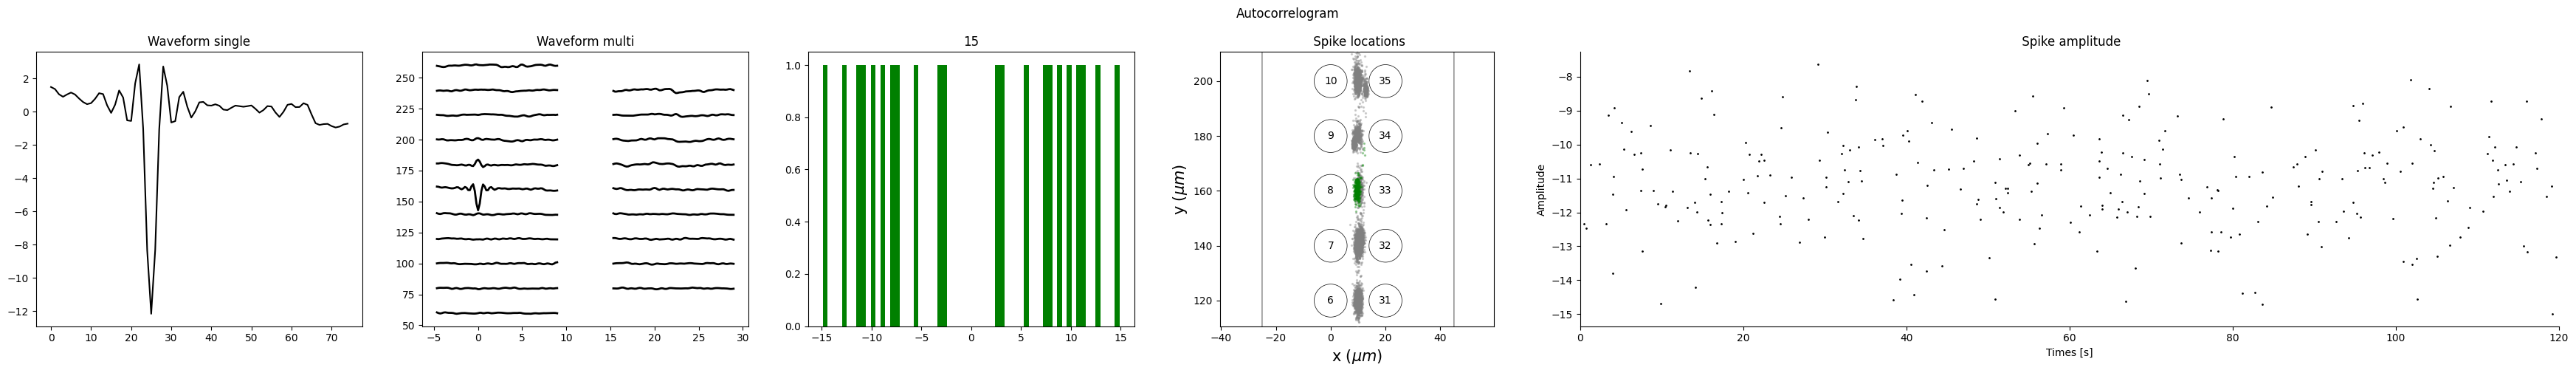

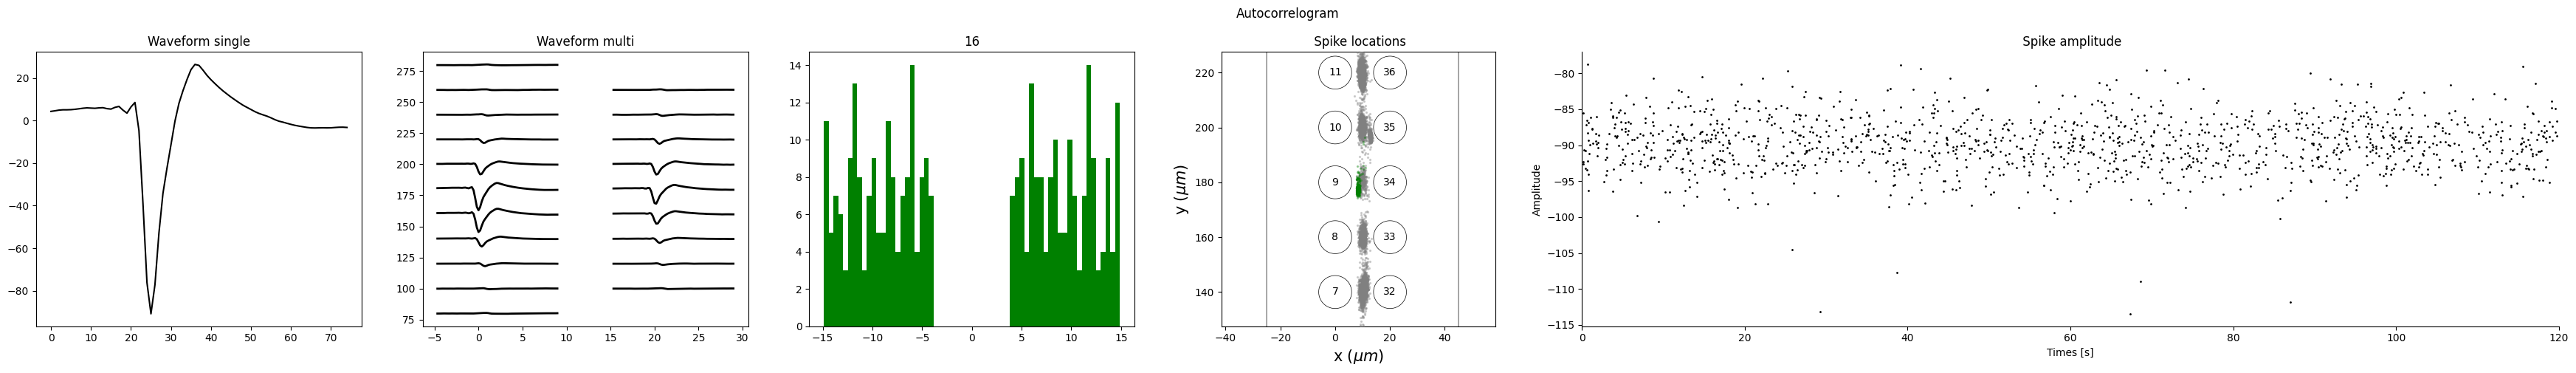

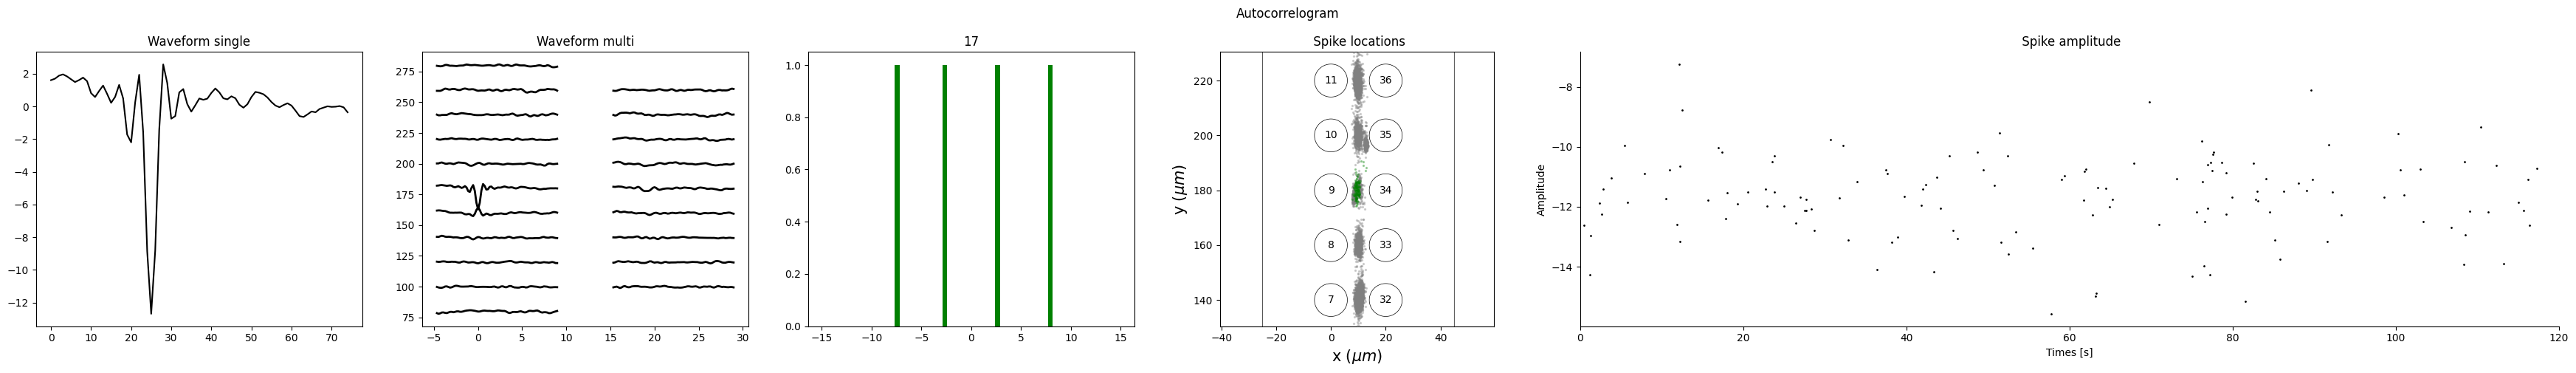

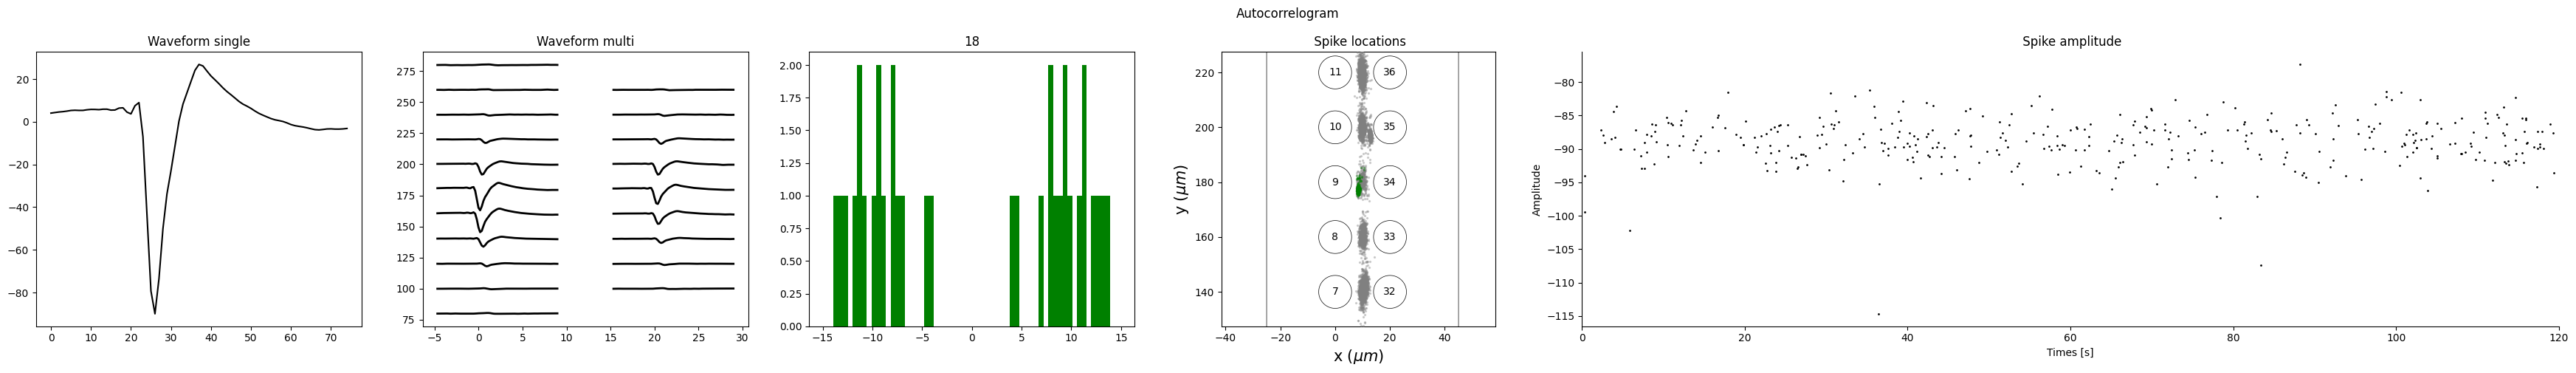

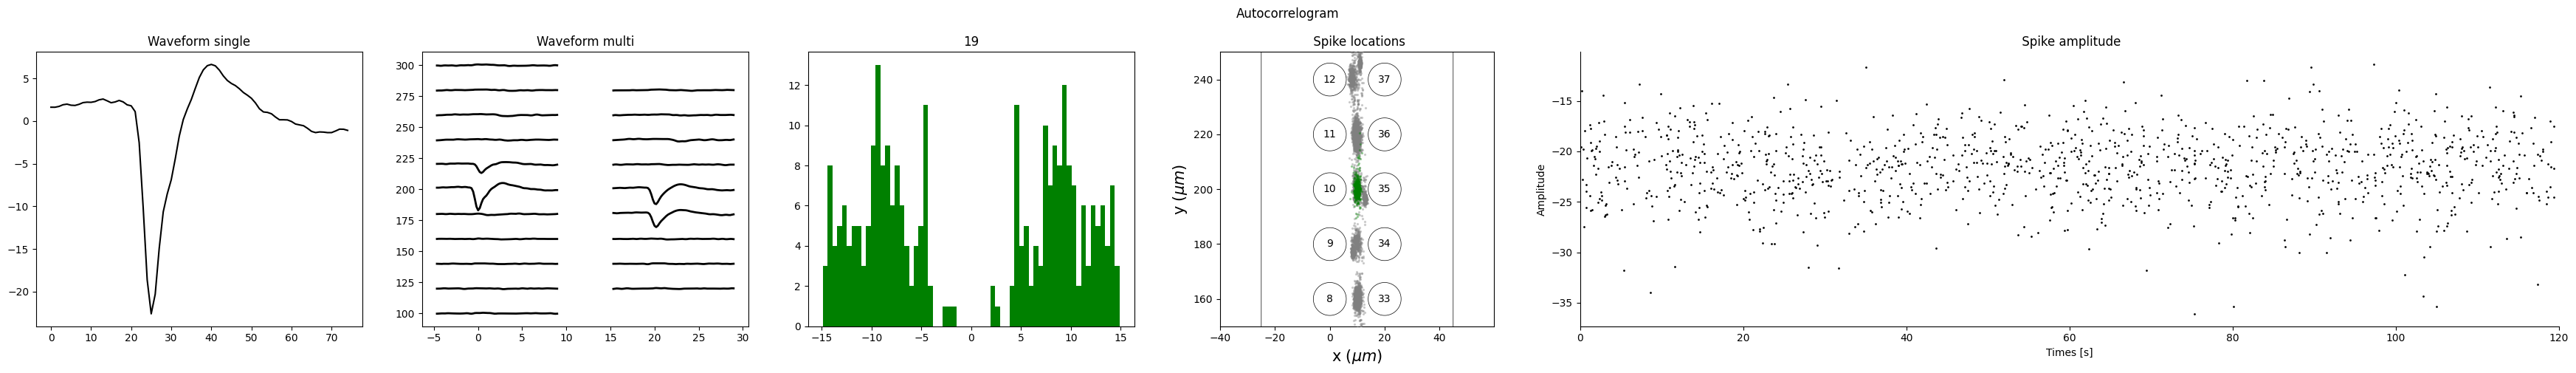

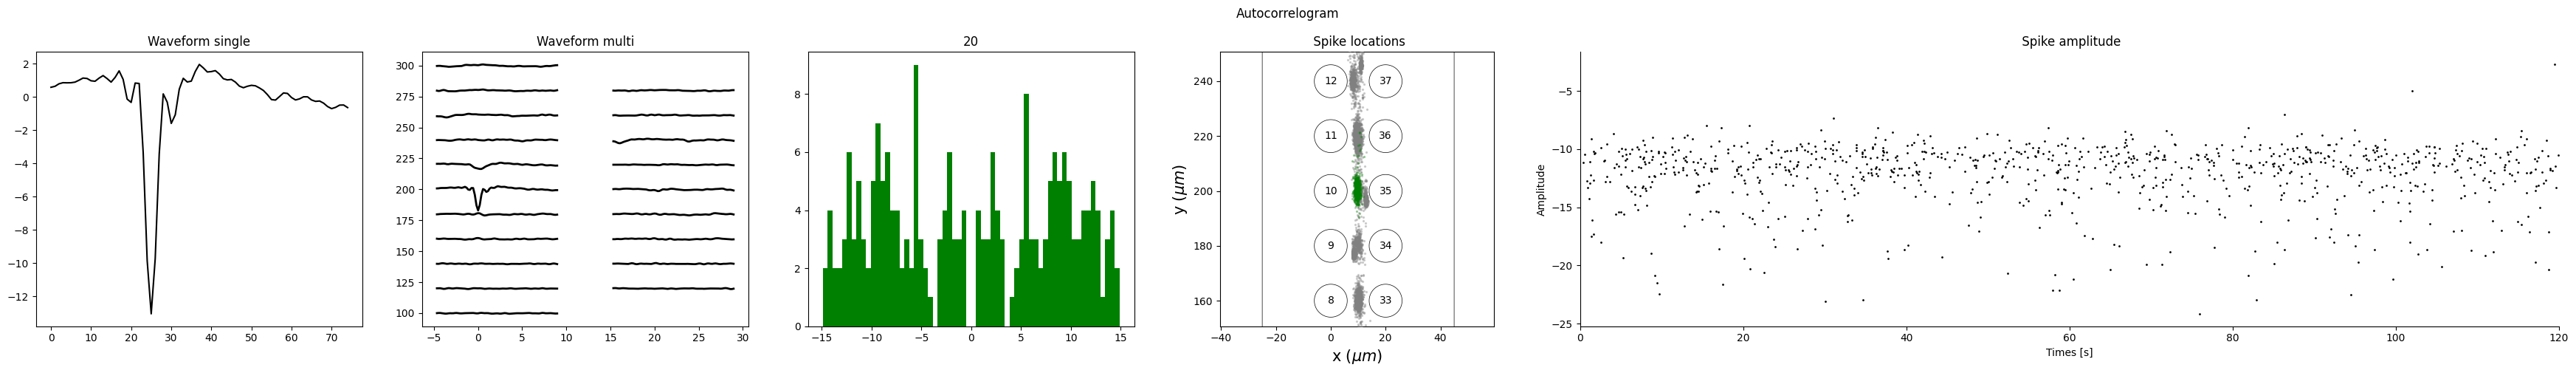

In [18]:
analyzer_to_use = sorting_analyzer
features_to_plot = ['waveform_single', 'waveform_multi', 'autocorr', 'spike_locations', 'amplitude_plot']
sic.plot_units_with_features(
    analyzer_to_use,
    unit_ids=analyzer_to_use.unit_ids[:20],
    features=features_to_plot,
    save=False,
)

In [19]:
from tool.vlm_curation import run_vlm_curation, plot_spike_images_with_result
from tool.utils import get_model
from dotenv import load_dotenv
import tool.si_custom as sic
load_dotenv()

True

In [20]:
unit_img_df = sic.create_unit_img_df(
    sorting_analyzer,
    unit_ids=None,
    load_if_exists=False,
    save_folder=sorting_folder
)

Encoding 86 unit images..


100%|██████████| 86/86 [03:04<00:00,  2.14s/it]


Unit images saved to moutainsort4_sorting/unit_img.csv


In [21]:
model = get_model(model_name='gpt-4o')
results_df_fewshot = run_vlm_curation(
    model=model,
    sorting_analyzer=sorting_analyzer,
    img_df=unit_img_df,
    features=["waveform_single", "waveform_multi", "autocorr", "spike_locations", "amplitude_plot"],
    good_ids=[1,4],
    bad_ids=[9,12],
    with_metrics=True,
    metrics_list=["snr","isi_violations_ratio","nn_hit_rate", "l_ratio"]
    )

Processing Units: 100%|██████████| 86/86 [12:17<00:00,  8.58s/unit]


In [22]:
unit_classes = results_df_fewshot.groupby('final_classification').groups
good_units = unit_classes.get('Good', []).tolist()
bad_units = unit_classes.get('Bad', []).tolist()
print('Final VLM Classification Results:')
print(f"Good units: {good_units}\\nBad units: {bad_units}")

Final VLM Classification Results:
Good units: [1, 3, 4, 5, 8, 10, 16, 18, 19, 21, 23, 24, 27, 29, 33, 34, 38, 42, 43, 47, 49, 55, 59, 62, 63, 66, 67, 68, 69, 71, 72, 73, 74, 76, 79, 80, 81, 82, 84, 85]\nBad units: [2, 6, 7, 9, 11, 12, 13, 14, 15, 17, 20, 22, 25, 26, 28, 30, 31, 32, 35, 36, 37, 39, 40, 41, 44, 45, 46, 48, 50, 51, 52, 53, 54, 56, 57, 58, 60, 61, 64, 65, 70, 75, 77, 78, 83, 86]


In [23]:
analyzer_curated = sorting_analyzer.remove_units(remove_unit_ids=bad_units)

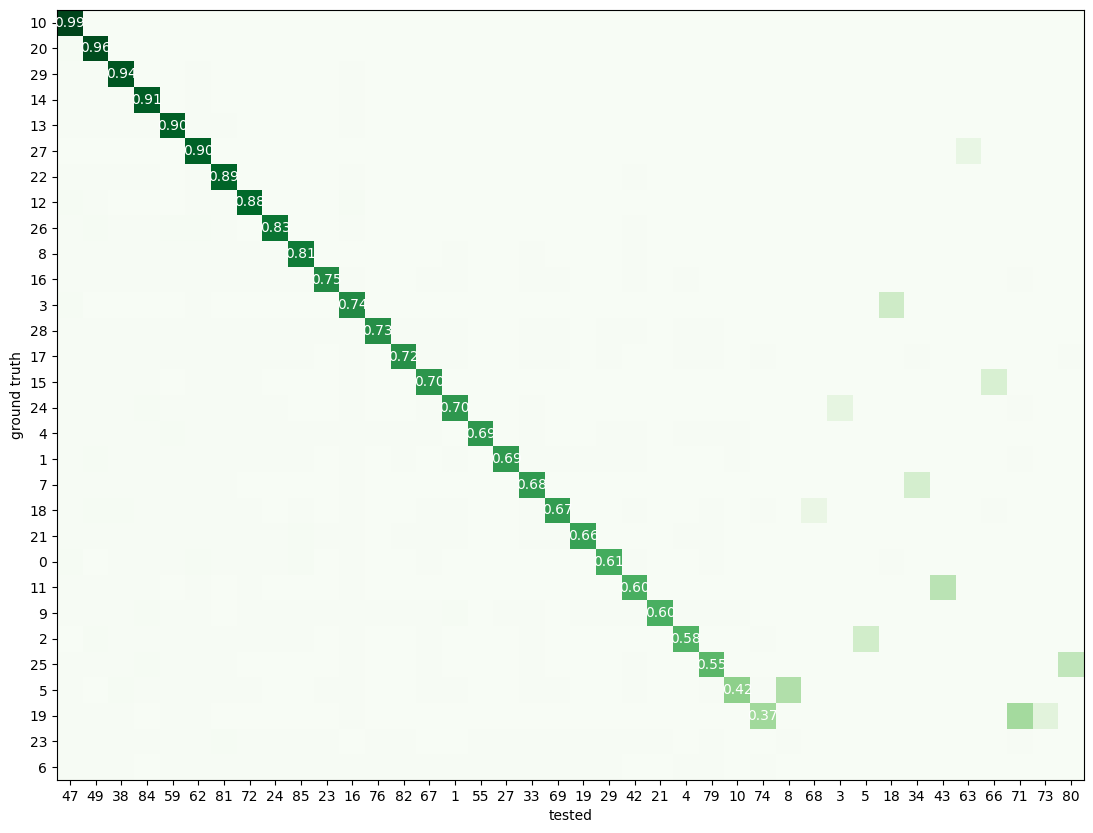

In [24]:
comp_gt_curated = si.compare_sorter_to_ground_truth(gt_sorting=gt_sorting0, tested_sorting=analyzer_curated.sorting, exhaustive_gt=True)
si.plot_agreement_matrix(comp_gt_curated, figsize=(20, 10))